In [0]:
from fastai.vision import *
from fastai.metrics import *
%matplotlib inline 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#persistent storage

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# path = datapath4file('gdrive/My Drive/fellowship/cars_dataset') #fastai function to get a PosixPath obj
# path_train = path/'train' #train folder with training images organized by class
# path_valid = path/'valid' #validation folder with validation images organized by class

path = 'gdrive/My Drive/fellowship/cars_dataset/'
path_train = path+'train/' 
path_valid = path+'valid/'



In [5]:
bs=64 #batch size

data = ImageDataBunch.from_folder(path, 'train', 'valid', size=224, bs=bs,) 
data.normalize(imagenet_stats) #normalizing to imagenet, always better to start from somewhere

ImageDataBunch;

Train: LabelList (3784 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0014,0014,0014,0014,0014
Path: gdrive/My Drive/fellowship/cars_dataset;

Valid: LabelList (955 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0091,0091,0091,0091,0091
Path: gdrive/My Drive/fellowship/cars_dataset;

Test: None

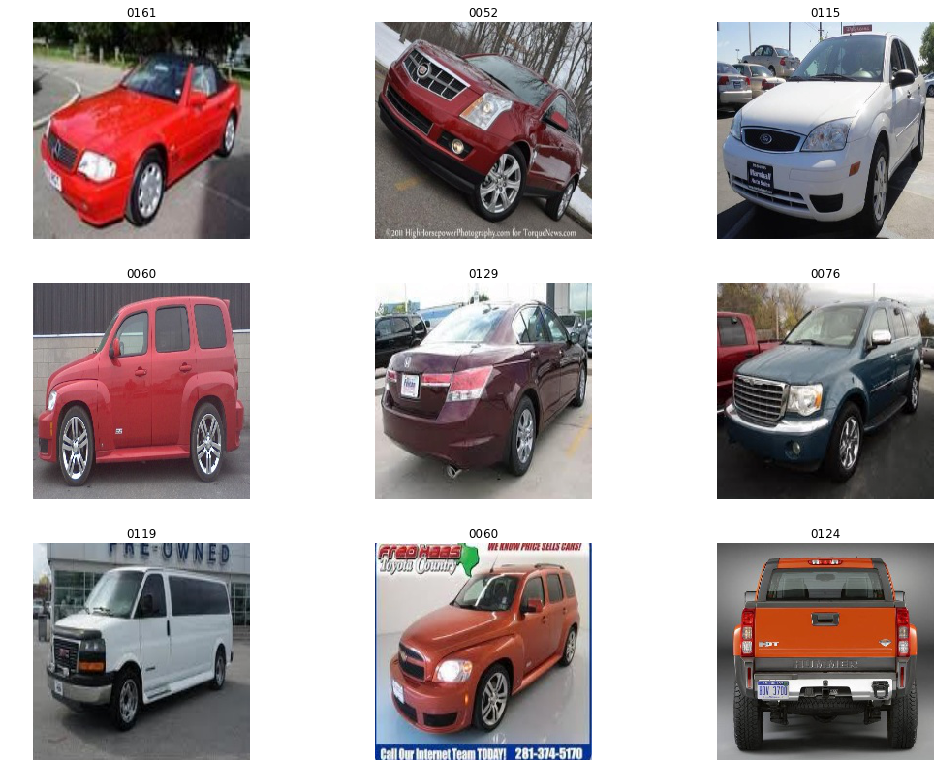

In [6]:
data.show_batch(rows=3, figsize=(15,11))

In [7]:
print(data.classes)

['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123', '0124', '0125',

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [17]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,4.968211,4.285906,0.130890,25:04


In [0]:
learn.save('../../../fellowship/Resnet34-1')